In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
sample_submission = pd.read_csv(
    'C:/Users/JADAV/OneDrive/MNIST/sample_submission.csv')

df_train = pd.read_csv('C:/Users/JADAV/Desktop/MNIST/train.csv')

df_test = pd.read_csv('C:/Users/JADAV/Desktop/MNIST/test.csv')

In [3]:
print(df_test.shape, df_train.shape)

(28000, 784) (42000, 785)


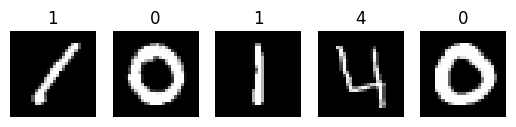

In [4]:
# Plot 5 sample digits
fig, axes = plt.subplots(1, 5)
for i, ax in enumerate(axes):
    ax.imshow(df_train.iloc[i, 1:].to_numpy().reshape(28, 28), cmap='gray')
    ax.set_title(df_train.iloc[i, 0])
    ax.axis('off')
plt.show()

PreProcessing


In [ ]:
from tensorflow.keras.utils import to_categorical  # type: ignore # One-hot encode

X = df_train.drop('label', axis=1).to_numpy()
y = df_train['label'].to_numpy()

# Normalize the pixel values  [0, 255] -> [0, 1]
X = X / 255.0

X = X.reshape(-1, 28, 28, 1)

y = to_categorical(y, 10)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# Build the CNN model

from tensorflow.keras import models, layers  # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Input  # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D  # type: ignore

# Define a model with convolutional layers
model_conv = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           input_shape=(28, 28, 1)),  # First convolutional layer
    # Max pooling layer
    MaxPooling2D(pool_size=(2, 2)),
    # Second convolutional layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Max pooling layer
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten the output
    Flatten(),
    # Fully connected layer
    Dense(128, activation='relu'),
    # Output layer
    Dense(10, activation='softmax')
])


model_conv.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


history_conv = model_conv.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=2,
                              batch_size=32)

c:\Users\msree\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.8826 - loss: 0.3802 - val_accuracy: 0.9808 - val_loss: 0.0623
Epoch 2/2
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9812 - loss: 0.0618 - val_accuracy: 0.9819 - val_loss: 0.0580


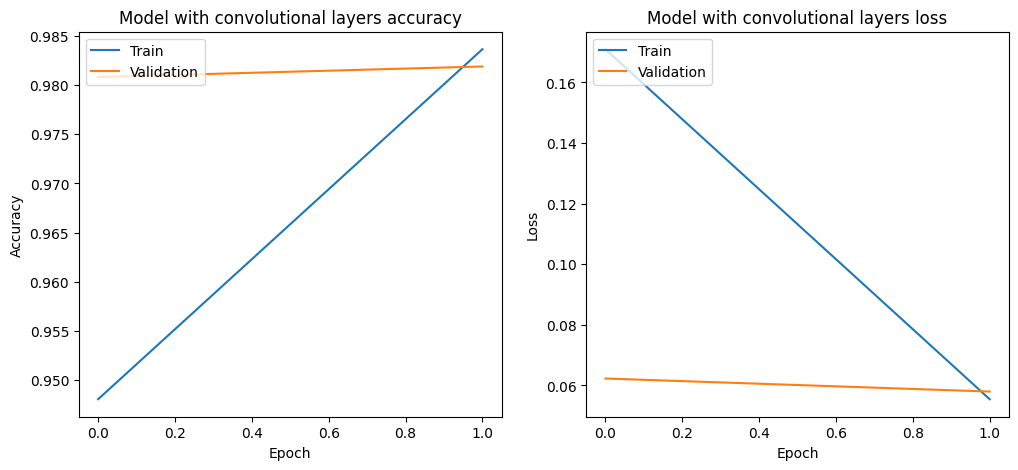

In [ ]:
def history_plot(history, model_name='Model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')


history_plot(history_conv, model_name='Model with convolutional layers')

In [ ]:
from tensorflow.keras.layers import Dropout
# Define a model with dropout
model_dropout = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           input_shape=(28, 28, 1)),  # First convolutional layer
    # Max pooling layer
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer
    Dropout(0.25),
    # Second convolutional layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    # Max pooling layer
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout layer
    Dropout(0.25),
    # Flatten the output
    Flatten(),
    # Fully connected layer
    Dense(128, activation='relu'),
    # Dropout layer
    Dropout(0.5),
    # Output layer
    Dense(10, activation='softmax')
])

model_dropout.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_dropout = model_dropout.fit(X_train, y_train,
                                    validation_data=(X_train, y_train),
                                    epochs=2,
                                    batch_size=32)

Epoch 1/2
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.7883 - loss: 0.6477 - val_accuracy: 0.9778 - val_loss: 0.0722
Epoch 2/2
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.9624 - loss: 0.1237 - val_accuracy: 0.9855 - val_loss: 0.0452


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Define the model creation function


def build_model(hp):
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
               kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        Conv2D(filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
               kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=128,
              max_value=512, step=128), activation='relu'),
        Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='my_dir1',
    project_name='intro_to_kt1'
)

tuner.search(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)

print(f"Best hyperparameters: {best_hps}")

Trial 2 Complete [00h 03m 13s]
val_accuracy: 0.9844047427177429

Best val_accuracy So Far: 0.9871428608894348
Total elapsed time: 00h 06m 00s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001D0056B68D0>


In [ ]:
history_best = best_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=2)

Epoch 1/2
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 84s 76ms/step - accuracy: 0.8802 - loss: 0.3717 - val_accuracy: 0.9799 - val_loss: 0.0699
Epoch 2/2
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 64s 61ms/step - accuracy: 0.9804 - loss: 0.0622 - val_accuracy: 0.9843 - val_loss: 0.0462


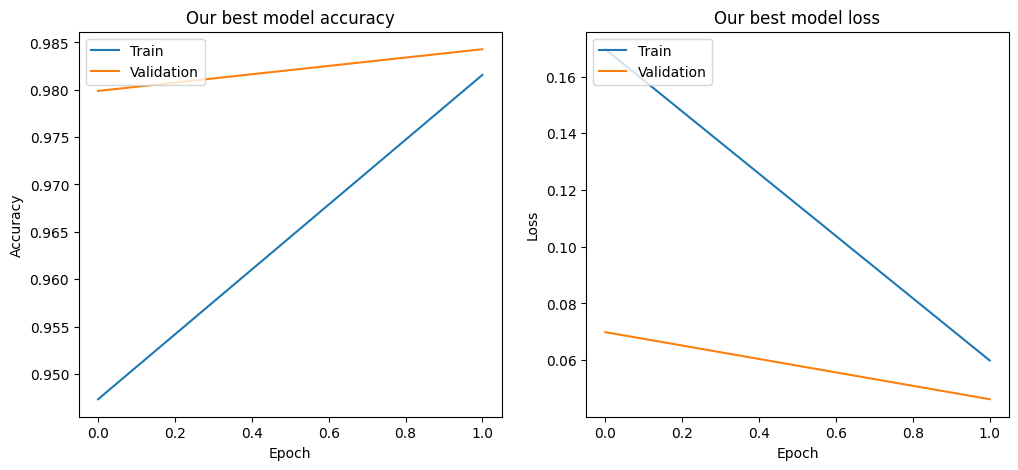

In [13]:
history_plot(history_best, model_name='Our best model')

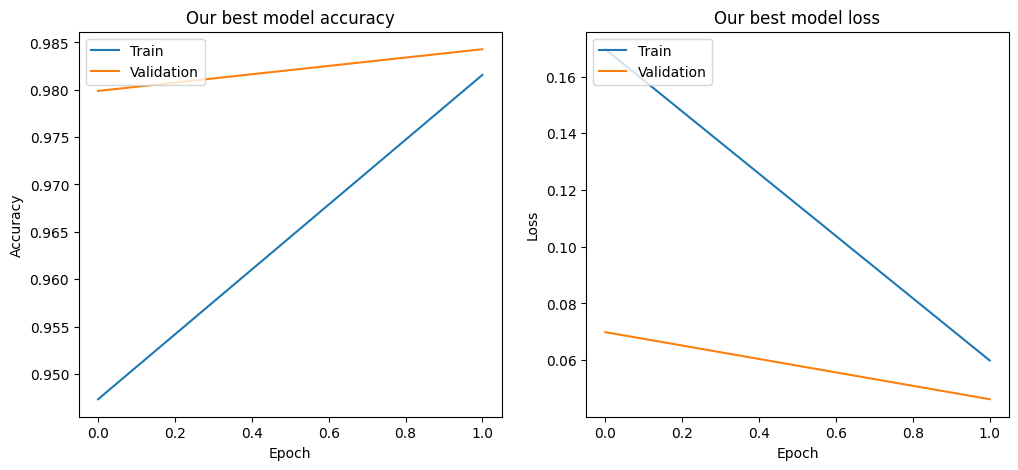

In [14]:
history_plot(history_best, model_name='Our best model')

In [15]:
y_val_pred = best_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


In [16]:
cnn_test_loss, cnn_test_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f'Test Loss: {cnn_test_loss}')
print(f'Test Accuracy: {cnn_test_accuracy}')

Test Loss: 0.046200405806303024
Test Accuracy: 0.9842857122421265


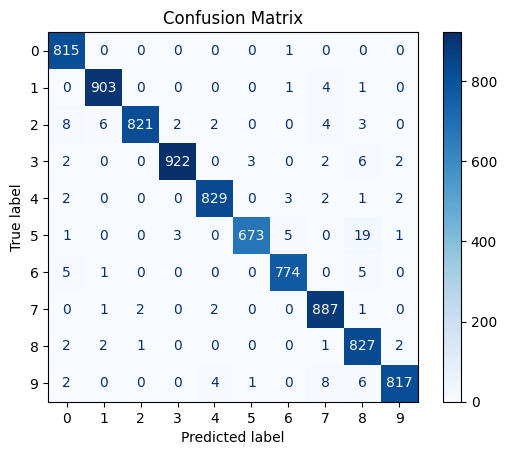

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                              str(i) for i in range(10)])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_test = df_test.values

X_test = X_test / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
y_final_pred = best_model.predict(X_test)
y_final_pred_classes = np.argmax(y_final_pred, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step


In [19]:
list(sample_submission)

['ImageId', 'Label']

In [20]:
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(y_final_pred_classes) + 1),
    'Label': y_final_pred_classes
})

submission.to_csv('submission.csv', index=False)

print("Results have been saved to 'submission.csv'")

Results have been saved to 'submission.csv'


Training Decision Tree model...

Validation accuracy: 0.8275

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       207
           1       0.92      0.94      0.93       222
           2       0.80      0.79      0.80       214
           3       0.79      0.72      0.76       245
           4       0.82      0.81      0.82       182
           5       0.72      0.74      0.73       156
           6       0.87      0.89      0.88       194
           7       0.88      0.85      0.87       213
           8       0.71      0.75      0.73       184
           9       0.78      0.82      0.80       183

    accuracy                           0.83      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.83      0.83      0.83      2000



<Figure size 1000x800 with 0 Axes>

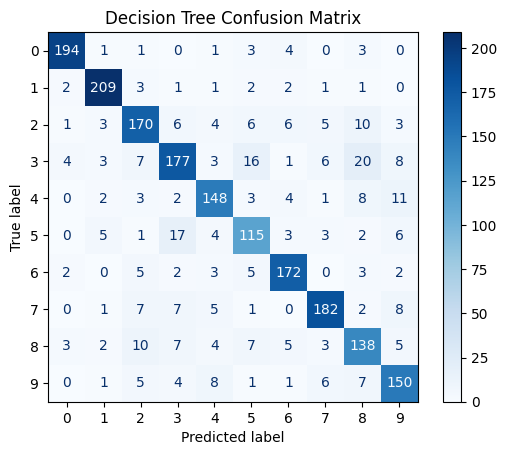

Making predictions on test set...
Results have been saved to 'submission_dt.csv'

Top 10 Most Important Features:
     feature  importance
434      434    0.064211
409      409    0.049716
155      155    0.047563
657      657    0.044754
239      239    0.042178
431      431    0.035652
270      270    0.033025
488      488    0.032206
375      375    0.031682
485      485    0.023232


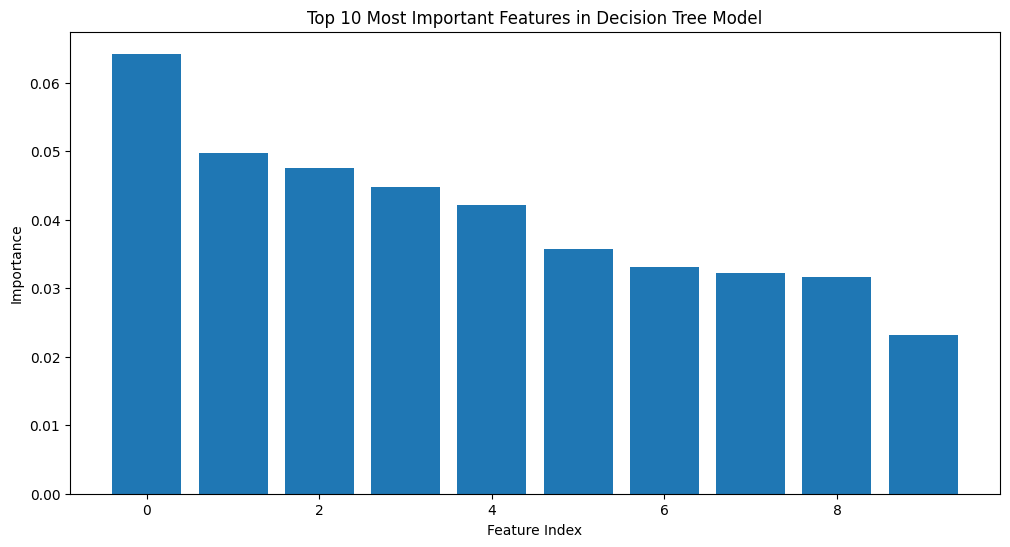

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# First, let's prepare the data for Decision Tree
# We'll use the same data preparation as SVM since Decision Trees can also work with flattened images

# Get original data
X = df_train.drop('label', axis=1).to_numpy()
y = df_train['label'].to_numpy()

# Normalize the pixel values [0, 255] -> [0, 1]
X = X / 255.0

# Split the data
X_train_dt, X_val_dt, y_train_dt, y_val_dt = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Unlike SVM, Decision Trees can handle larger datasets more efficiently
# But we can still use a subset if needed for faster training
train_size = 20000  # Using more samples than SVM as Decision Trees are faster
X_train_subset = X_train_dt[:train_size]
y_train_subset = y_train_dt[:train_size]
X_val_subset = X_val_dt[:2000]  # Using 2000 samples for validation
y_val_subset = y_val_dt[:2000]

# Create and train Decision Tree model
print("Training Decision Tree model...")
dt_model = DecisionTreeClassifier(
    max_depth=20,          # Prevent overfitting
    min_samples_split=10,  # Minimum samples required to split an internal node
    min_samples_leaf=5,    # Minimum samples required to be at a leaf node
    random_state=42
)

# Train the model
dt_model.fit(X_train_subset, y_train_subset)

# Make predictions on validation set
y_val_pred_dt = dt_model.predict(X_val_subset)

# Calculate accuracy
dt_accuracy = accuracy_score(y_val_subset, y_val_pred_dt)
print(f"\nValidation accuracy: {dt_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_val_subset, y_val_pred_dt))

# Create confusion matrix
cm_dt = confusion_matrix(y_val_subset, y_val_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[
                              str(i) for i in range(10)])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Make predictions on test set and create submission
print("Making predictions on test set...")
X_test_dt = X_test.reshape(X_test.shape[0], -1)  # Flatten test data
y_test_pred_dt = dt_model.predict(X_test_dt)

# Create submission DataFrame
submission_dt = pd.DataFrame({
    'ImageId': np.arange(1, len(y_test_pred_dt) + 1),
    'Label': y_test_pred_dt
})

# Save predictions
submission_dt.to_csv('submission_dt.csv', index=False)
print("Results have been saved to 'submission_dt.csv'")

# Print feature importance (additional insight for Decision Trees)
feature_importance = pd.DataFrame({
    'feature': range(X.shape[1]),
    'importance': dt_model.feature_importances_
})
top_features = feature_importance.nlargest(10, 'importance')
print("\nTop 10 Most Important Features:")
print(top_features)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(10), top_features['importance'])
plt.title('Top 10 Most Important Features in Decision Tree Model')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
print("Performing grid search for Decision Tree hyperparameters...")
grid_search.fit(X_train_subset, y_train_subset)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model for predictions
best_dt_model = grid_search.best_estimator_

Performing grid search for Decision Tree hyperparameters...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.8286


In [25]:
# Print comparison
print("\nModel Accuracy Comparison:")
print("-" * 30)
print(f"CNN Accuracy: {cnn_test_accuracy:.4f}")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")


Model Accuracy Comparison:
------------------------------
CNN Accuracy: 0.9843
Decision Tree Accuracy: 0.8275
